# SHAP Values Explanation - Sensor Measurements 

FD_001: 
- Subjected to 1 type of flight condition
- One type of failure mode

This notebook aims to detect the sensors that are more significant in prediction of RUL.
Since there is only one type of flight condition in dataset, we ignore the 3 operational setting.

As for the Cycle number, it acts as an indication of time step of the data. Thus we experiment with and without the feature 'Cycle' in our results.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy
import statsmodels.api as sm

In [3]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy
import statsmodels.api as sm

In [4]:
# Data
df_train = pd.read_csv("CMaps/train_FD001.txt", sep=" ", header=None)
df_test = pd.read_csv("CMaps/test_FD001.txt", sep=" ", header=None)
df_rul = pd.read_csv("CMaps/RUL_FD001.txt", sep=" ", header=None)

In [5]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")
print(f"RUL: {df_rul.shape}")

Train: (20631, 28)
Test: (13096, 28)
RUL: (100, 2)


In [6]:
columns = ['Engine_ID', 'Cycle',
          'ALT', 'Mach', 'TRA',
          'T2', 'T24', 'T30', 'T50',
           'P2', 'P15', 'P30',
           'Nf', 'Nc', 'epr', 'Ps30', 'phi',
           'NRf', 'NRc', 'BPR', 'farB',
           'htBleed', 'Nf_dmd', 'PCNfR_dmd',
           'W31', 'W32', "SD_22", "SD_23"
          ]

In [7]:
df_train.columns = columns
df_test.columns = columns

In [8]:
# Count number of unique engines
print(f"df_train unique engines: {df_train['Engine_ID'].nunique()}")
print(f"df_test unique engines: {df_test['Engine_ID'].nunique()}")

df_train unique engines: 100
df_test unique engines: 100


In [9]:
print(f"df_rul engines count: {len(df_rul)}")

df_rul engines count: 100


In [10]:
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('Engine_ID')['Cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['Engine_ID','max']
    df = df.merge(fd_RUL, on=['Engine_ID'], how='left')
    df['RUL'] = df['max'] - df['Cycle']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['Cycle'] > factor]

In [11]:
df_train = prepare_train_data(df_train, factor = 0)

In [12]:
display(df_train)

,Engine_ID,Cycle,ALT,Mach,TRA,T2,T24,T30,T50,P2,...,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,SD_22,SD_23,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1


In [13]:
# Add RUL to df_test

df_test = df_test.groupby('Engine_ID').last().reset_index()
print(len(df_test))

# Add max RUL to df_test
# Make list of df_rul
max_rul = df_rul[0].tolist() #len = 100

# Create actual RUL column: MAX_RUL - Cycle
df_test["RUL"] = max_rul

100


In [14]:
display(df_test)

,Engine_ID,Cycle,ALT,Mach,TRA,T2,T24,T30,T50,P2,...,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,SD_22,SD_23,RUL
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,8.4024,0.03,393,2388,100.0,38.81,23.3552,NaN,NaN,112
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,8.4505,0.03,391,2388,100.0,38.81,23.2618,NaN,NaN,98
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,8.4119,0.03,395,2388,100.0,38.93,23.2740,NaN,NaN,69
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,8.4634,0.03,395,2388,100.0,38.58,23.2581,NaN,NaN,82
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,8.4362,0.03,394,2388,100.0,38.75,23.4117,NaN,NaN,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,8.4110,0.03,391,2388,100.0,38.96,23.4606,NaN,NaN,137
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,8.4500,0.03,395,2388,100.0,38.61,23.2953,NaN,NaN,82
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,8.4235,0.03,394,2388,100.0,38.76,23.3608,NaN,NaN,59
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,8.4003,0.03,391,2388,100.0,38.95,23.3595,NaN,NaN,117


In [15]:
#

features = ['T2', 'T24', 'T30', 'T50',
           'P2', 'P15', 'P30',
           'Nf', 'Nc', 'epr', 'Ps30', 'phi',
           'NRf', 'NRc', 'BPR', 'farB',
           'htBleed', 'Nf_dmd', 'PCNfR_dmd',
           'W31', 'W32']

output = ['RUL']

In [16]:
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[output]
y_test = df_test[output]

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
gb_reg = GradientBoostingRegressor(random_state=0, criterion='friedman_mse')

In [19]:
gb_reg.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(random_state=0)

In [20]:
# Metrics
predictions = gb_reg.predict(X_test)
predictions_2 = np.array([[i] for i in predictions])
mae = np.mean(abs(predictions_2 - y_test))
rmse = np.sqrt(np.mean((predictions_2 - y_test) ** 2))
print('Using GB Regressor, MAE is %0.2f' %  mae)  
print('Using GB Regressor, RMSE is %0.2f' %  rmse) 

Using GB Regressor, MAE is 23.35
Using GB Regressor, RMSE is 32.30


In [21]:
# SHaP
import shap

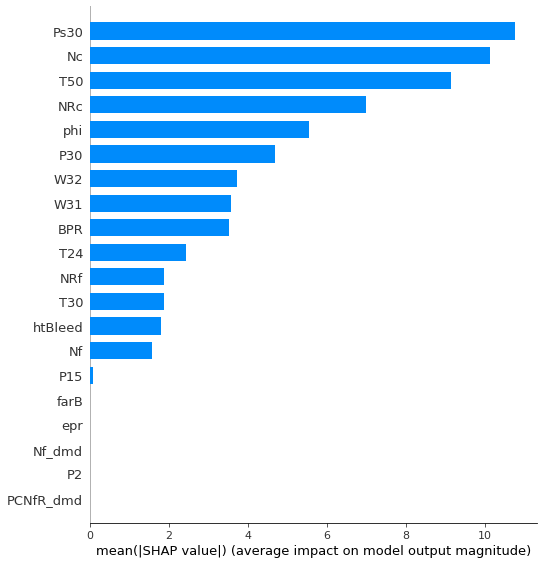

In [22]:
shap_values = shap.TreeExplainer(gb_reg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

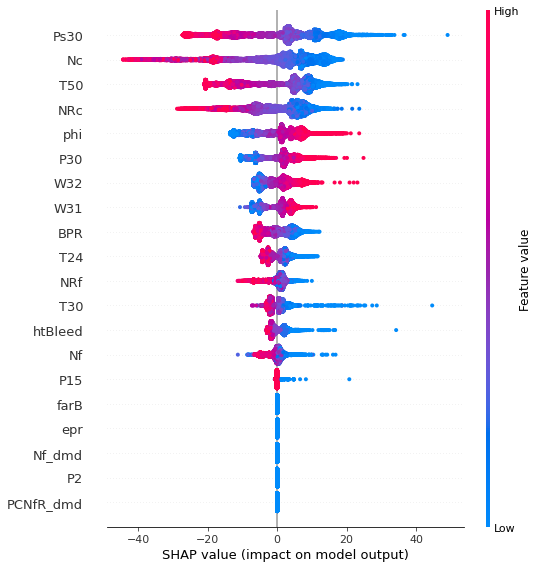

In [23]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [24]:
# Local Interpretability
np.arange(1,100,10)

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [25]:
X_test.shape

(100, 21)

In [26]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(gb_reg.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(0,100,1) # Every 50 rows
S = X_output.iloc[random_picks]
S

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,predict
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,173.07
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,138.54
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,71.30
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581,103.96
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117,135.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,518.67,642.30,1590.88,1397.94,14.62,21.61,553.99,2388.03,9062.41,1.3,...,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606,168.07
96,518.67,642.59,1582.96,1410.92,14.62,21.61,554.05,2388.06,9076.36,1.3,...,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953,74.27
97,518.67,642.68,1599.51,1415.47,14.62,21.61,553.44,2388.13,9062.34,1.3,...,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608,93.07
98,518.67,642.00,1585.03,1397.98,14.62,21.61,554.75,2388.01,9067.16,1.3,...,2388.02,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595,155.40


In [27]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(gb_reg)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [28]:
shap_plot(90)

In [ ]:
# On X_test

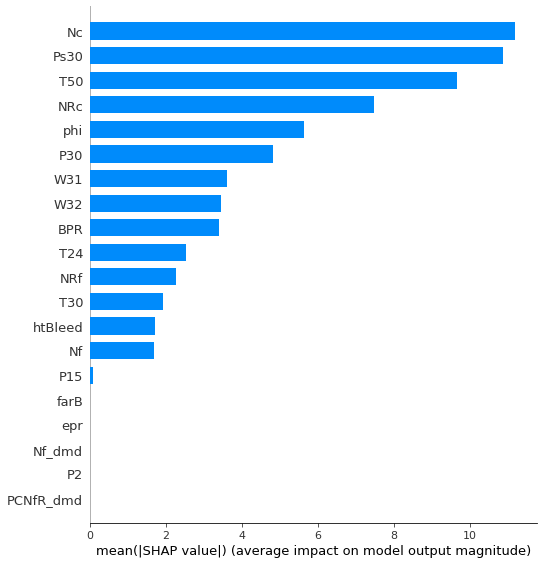

In [29]:
shap_values = shap.TreeExplainer(gb_reg).shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")

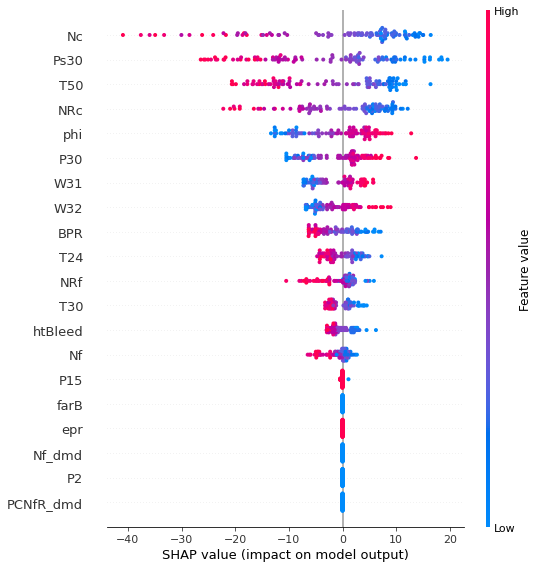

In [32]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [29]:
End of SHAP

NameError: name 'STOP' is not defined

In [ ]:
# Feature Importance Comparison

In [ ]:
gb_reg.feature_importances_

In [ ]:
importances = gb_reg.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gb_reg.estimators_],
             axis=0)
indices = np.argsort(importances)
y_label = [features[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), y_label)
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [ ]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(15,8))
feat_importances = pd.Series(gb_reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Dataset 1 - Feature Importance")
plt.show()

In [ ]:
#

features = ['Cycle', 'T2', 'T24', 'T30', 'T50',
           'P2', 'P15', 'P30',
           'Nf', 'Nc', 'epr', 'Ps30', 'phi',
           'NRf', 'NRc', 'BPR', 'farB',
           'htBleed', 'Nf_dmd', 'PCNfR_dmd',
           'W31', 'W32']

output = ['RUL']

In [ ]:
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[output]
y_test = df_test[output]

In [ ]:
gb_reg = GradientBoostingRegressor(random_state=0, criterion='friedman_mse')

In [ ]:
gb_reg.fit(X_train, y_train.values.ravel())

In [ ]:
# Metrics
predictions = gb_reg.predict(X_test)
predictions_2 = np.array([[i] for i in predictions])
mae = np.mean(abs(predictions_2 - y_test))
rmse = np.sqrt(np.mean((predictions_2 - y_test) ** 2))
print('Using GB Regressor, MAE is %0.2f' %  mae)  
print('Using GB Regressor, RMSE is %0.2f' %  rmse) 

In [ ]:
gb_reg.feature_importances_

In [ ]:
importances = gb_reg.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gb_reg.estimators_],
             axis=0)
indices = np.argsort(importances)
y_label = [features[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), y_label)
plt.ylim([-1, X_train.shape[1]])
plt.show()